**Created by Sanskar Hasija**

**🧐Object detection using TFhub🧐**

**18 NOVEMBER 2021**


# <center>🧐OBJECT DETECTION USING TFHUB🧐 </center>
## <center>If you find this notebook useful, support with an upvote👍</center>

### This notebook is an end-to-end notebook for objection detection in images using pre-trained models from TensorFlow Hub.
### Check out Tensorflow-hub [here](https://www.tensorflow.org/hub).

### [1. Imports](#1) ###
### [2. Loading Models](#2) ##
### [3. Utility Functions](#3) ###
### [4. Inference on different images](#4) ###


<a id="1"></a>
# <center>Imports</center>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageColor, ImageDraw , ImageFont , ImageOps
from IPython.display import display, Markdown ,clear_output

import tensorflow as tf 
import tensorflow_hub as hub

import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO
import time

<a id="2"></a>
# <center>Loading Models</center>

##### There are 60+ pre-trained models available on Tensorflow-Hub for object detection in images. Check them [here](https://tfhub.dev/s?module-type=image-object-detection).
##### You can select any model for inference by just copying the URL of that model from TF-HUB.
##### Each model differs in size , accuracy, loading and inferencing time.

#### In this notebook, I will use and compare 2 different models.

#### 1. [SSD + MobileNet V2](https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2): Small and fast.
#### 2. [FasterRCNN + InceptionResNet V2](https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1): High Accuracy

### Model's URL

In [2]:
ssd_url = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"
inception_resnet_v2_url = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

### Loading both models

In [3]:
ssd_model = hub.load(ssd_url)
ssd_detector = ssd_model.signatures['default']

icp_resv2_model = hub.load(inception_resnet_v2_url)
icp_res2_detector = icp_resv2_model.signatures['default']
clear_output()

<a id="3"></a>
# <center>Utility Functions </center>

In [4]:
def resize_image(url , img_height = 256, img_width = 256):
    '''
    Fetches an image online, resizes it and saves it locally.
    
    Args:
        url (string) -- link to the image
        new_width (int) -- size in pixels used for resizing the width of the image
        new_height (int) -- size in pixels used for resizing the length of the image
        
    Returns:
        (string) -- path to the saved image
    '''
    response = urlopen(url)
    img = response.read()
    img = BytesIO(img)
    pil_image = Image.open(img)
    pil_image = ImageOps.fit(pil_image, (img_height, img_width), Image.ANTIALIAS)
    pil_image_rgb= pil_image.convert("RGB")
    _, filename = tempfile.mkstemp(suffix=".jpg")
    pil_image_rgb.save(filename, format="JPEG", quality=90) # save images to a temporary location
    #print("Image downloaded to %s." % filename)
    return filename


def display_image(image , detector_name):
    """
    Displays an image inside the notebook.
    """
    fig = plt.figure(figsize = (15,10))
    plt.grid(False)
    plt.title(detector_name , fontdict = {'fontsize' : 20} )
    plt.imshow(image)
    
    
def load_image(img_path):
    '''
    Loads a JPEG image and converts it to a tensor.
    
    Args:
        path-- path to a locally saved JPEG image
    
    Returns:
        an image tensor
    '''
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image,channels = 3 )
    return image


def draw_bb(image , ymin ,xmin , ymax , xmax , color , font , thickness = 4 , display_str_list = ()):
    """
    Adds a bounding box to an image.
    Args:
        image -- the image object
        ymin -- bounding box coordinate
        xmin -- bounding box coordinate
        ymax -- bounding box coordinate
        xmax -- bounding box coordinate
        color -- color for the bounding box edges
        font -- font for class label
        thickness -- edge thickness of the bounding box
        display_str_list -- class labels for each object detected
    Returns:
        No return.  The function modifies the `image` argument 
                    that gets passed into this function
    
    """
    draw = ImageDraw.Draw(image)
    width , height = image.size
    # scale the bounding box coordinates to the height and width of the image
    (left , right , top , bottom ) = (xmin * width , xmax * width, 
                                     ymin * height , ymax * height) 
    # define the four edges of the detection box
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),(left, top)], 
            width=thickness,
            fill=color)
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)
    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
    for display_str in display_str_list[::-1]:
        text_width , text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin
        
        
def draw_boxes(image , boxes , class_names , scores , max_boxes = 10 , min_score = 0.1):
    """
    Overlay labeled boxes on an image with formatted scores and label names.
    
    Args:
        image -- the image as a numpy array
        boxes -- list of detection boxes
        class_names -- list of classes for each detected object
        scores -- numbers showing the model's confidence in detecting that object
        max_boxes -- maximum detection boxes to overlay on the image (default is 10)
        min_score -- minimum score required to display a bounding box
    
    Returns:
        image -- the image after detection boxes and classes are overlaid on the original image.
    """
    colors = list(ImageColor.colormap.values())
    font = ImageFont.load_default()
    
    for i in range(min(boxes.shape[0] ,max_boxes)):
        
        if scores[i] >= min_score:# only display detection boxes that have the minimum score or higher
            ymin , xmin , ymax , xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bb(image_pil, ymin ,xmin , ymax ,xmax, color , font ,display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image


def run_detector(detector,detector_name , image_path):
    '''
    Runs inference on a local file using an object detection model.
    Args:
        detector (model) -- an object detection model loaded from TF Hub
        path -- path to an image saved locally
    '''
    image = load_image(image_path) # loads an image tesnor 
    converted_image = tf.image.convert_image_dtype(image ,tf.float32)[tf.newaxis,...] # adds a batch dimension 
    # Running Inference on image 
    start_time = time.time()
    result = detector(converted_image)
    end_time = time.time()
    
    result = {key:value.numpy() for key,value in result.items()}
    
    print(detector_name + " Found %d objects." %len(result["detection_scores"]))
    print(detector_name + " Inference Time:" , end_time - start_time)
    #Drawing bounding box on image
    image_with_bb = draw_boxes(image.numpy() , result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])
    
    display_image(image_with_bb, detector_name)
    
def object_detector(detector , detector_name , image_url , img_height = 640 , img_width = 480):
    image_path = resize_image(image_url , img_height ,img_width)
    run_detector(detector ,detector_name, image_path)

<a id="4"></a>
# <center>Inference on different images</center>

### URL of 5 different images

In [5]:
image_urls = ["https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg",
             "https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg",
             "https://upload.wikimedia.org/wikipedia/commons/0/02/Paso_de_cebra_en_el_centro_de_Ciudad_de_M%C3%A9xico.jpg",
             "https://upload.wikimedia.org/wikipedia/commons/3/3c/Peak_hour_traffic_in_melbourne.jpg",
             "https://upload.wikimedia.org/wikipedia/commons/a/a1/Aepyceros_melampus_petersi_female_8014.jpg"]

### Checking results on all 5 images

## Inference on image 1

SSD + MobileNetV2 Detector Found 100 objects.
SSD + MobileNetV2 Detector Inference Time: 10.016385793685913


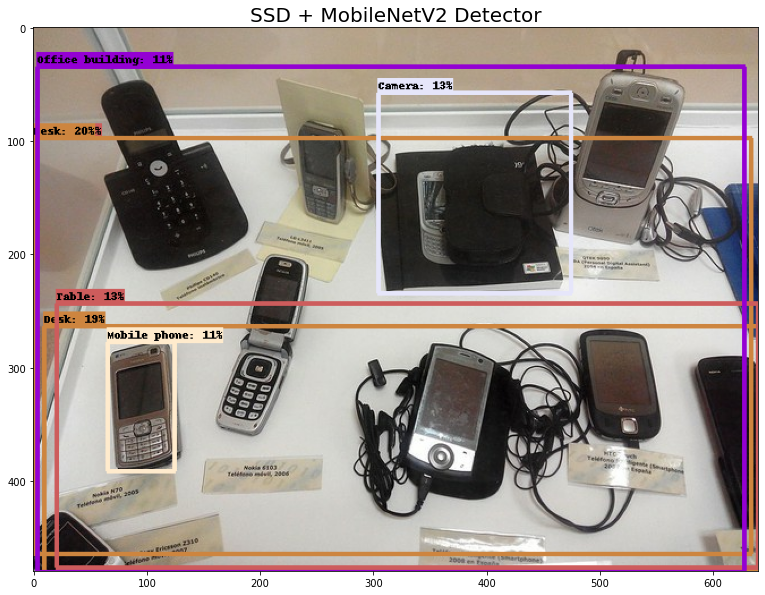

FasterRCNN + InceptionResNet V2 Detector Found 100 objects.
FasterRCNN + InceptionResNet V2 Detector Inference Time: 71.20075917243958


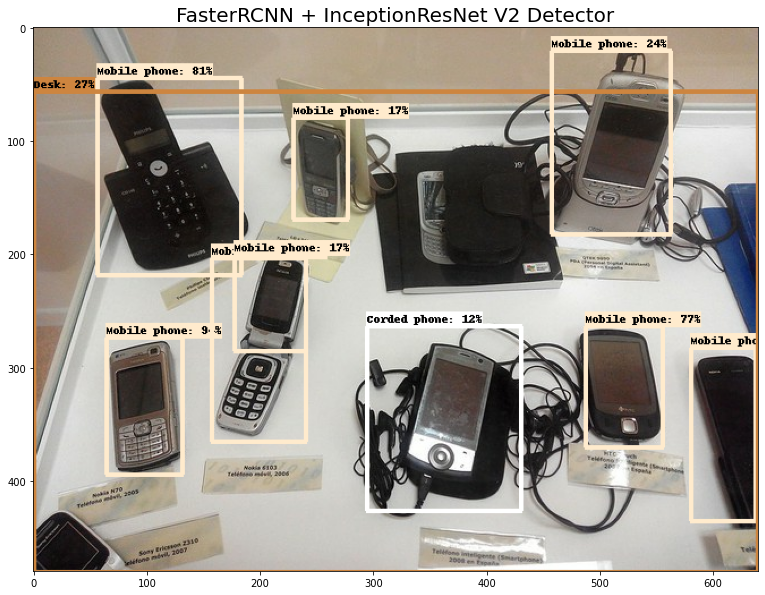

## Inference on image 2

SSD + MobileNetV2 Detector Found 100 objects.
SSD + MobileNetV2 Detector Inference Time: 0.2733023166656494


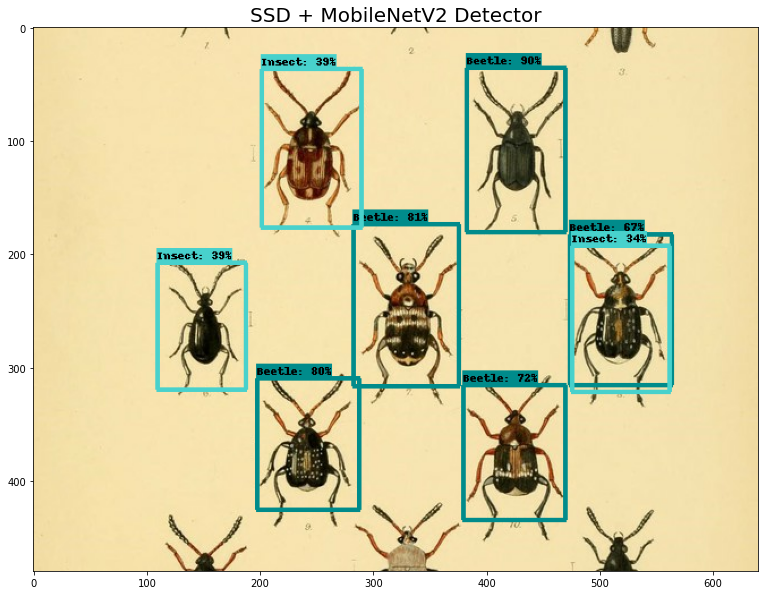

FasterRCNN + InceptionResNet V2 Detector Found 100 objects.
FasterRCNN + InceptionResNet V2 Detector Inference Time: 13.941383123397827


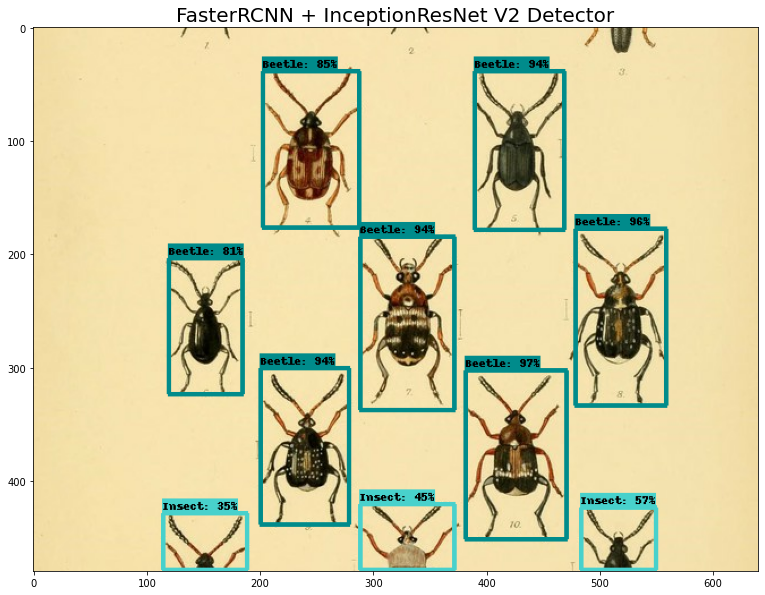

## Inference on image 3

SSD + MobileNetV2 Detector Found 100 objects.
SSD + MobileNetV2 Detector Inference Time: 0.2609076499938965


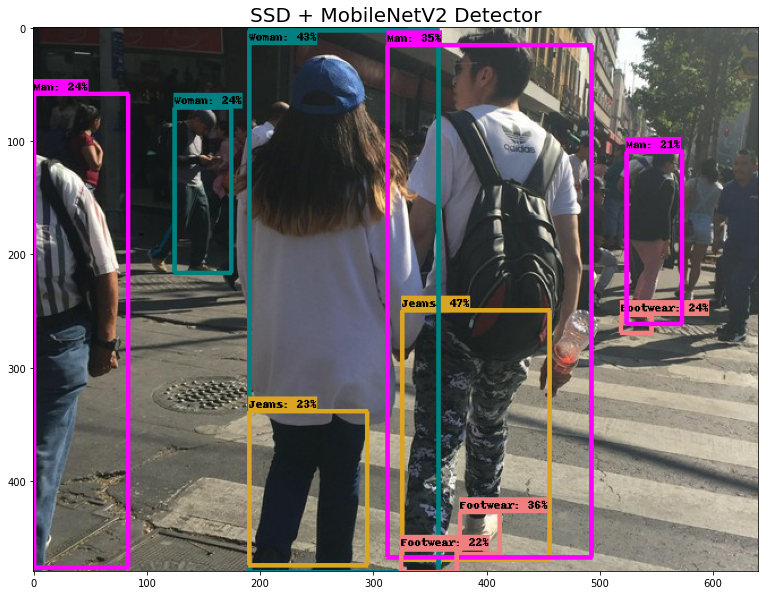

FasterRCNN + InceptionResNet V2 Detector Found 100 objects.
FasterRCNN + InceptionResNet V2 Detector Inference Time: 13.549901008605957


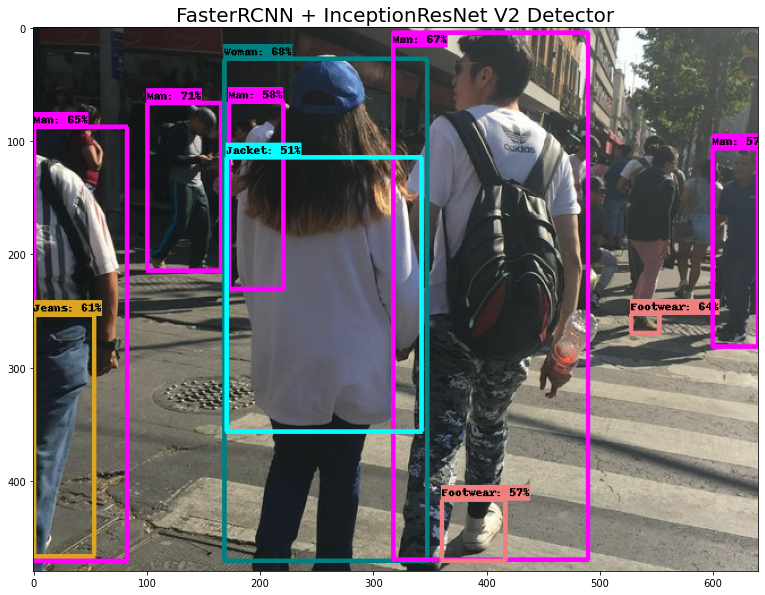

## Inference on image 4

SSD + MobileNetV2 Detector Found 100 objects.
SSD + MobileNetV2 Detector Inference Time: 0.2725505828857422


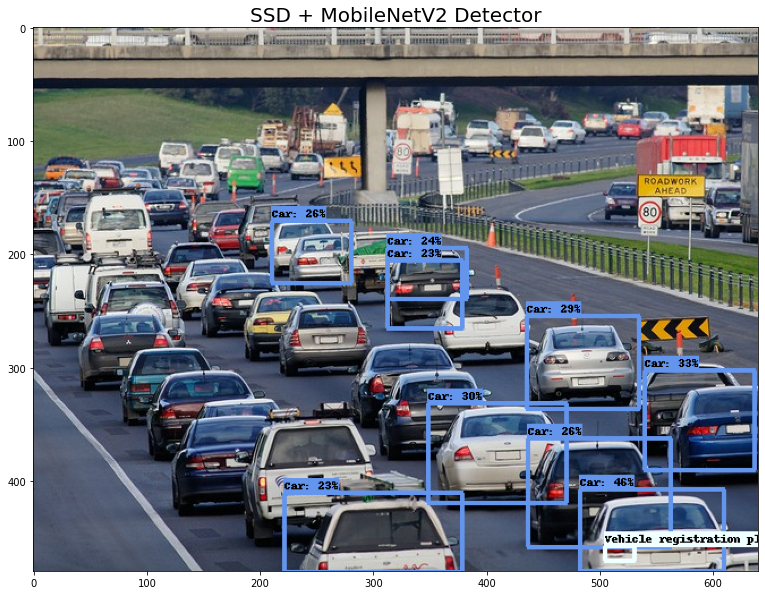

FasterRCNN + InceptionResNet V2 Detector Found 100 objects.
FasterRCNN + InceptionResNet V2 Detector Inference Time: 13.758187532424927


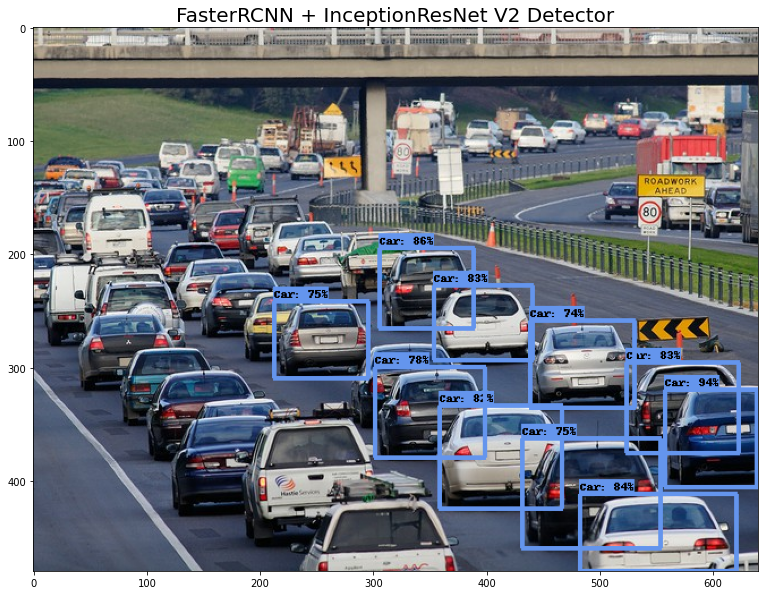

## Inference on image 5

SSD + MobileNetV2 Detector Found 100 objects.
SSD + MobileNetV2 Detector Inference Time: 0.2514629364013672


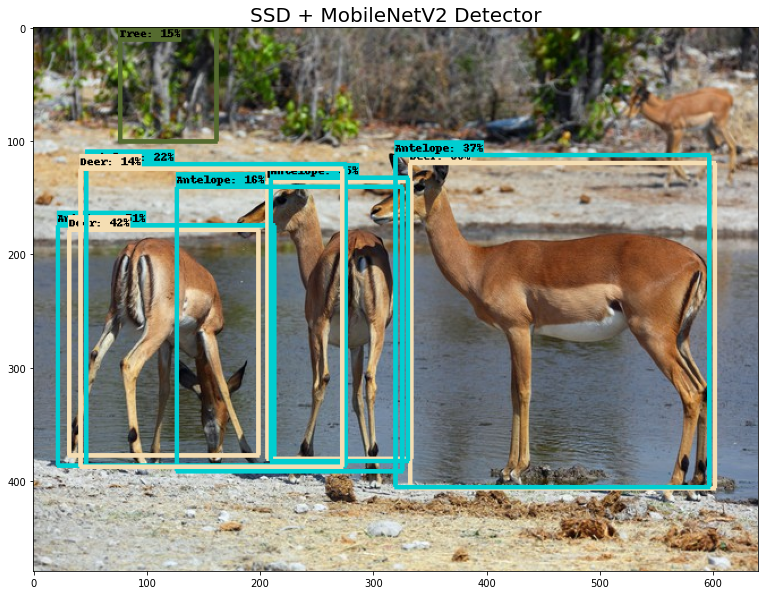

FasterRCNN + InceptionResNet V2 Detector Found 100 objects.
FasterRCNN + InceptionResNet V2 Detector Inference Time: 13.481933832168579


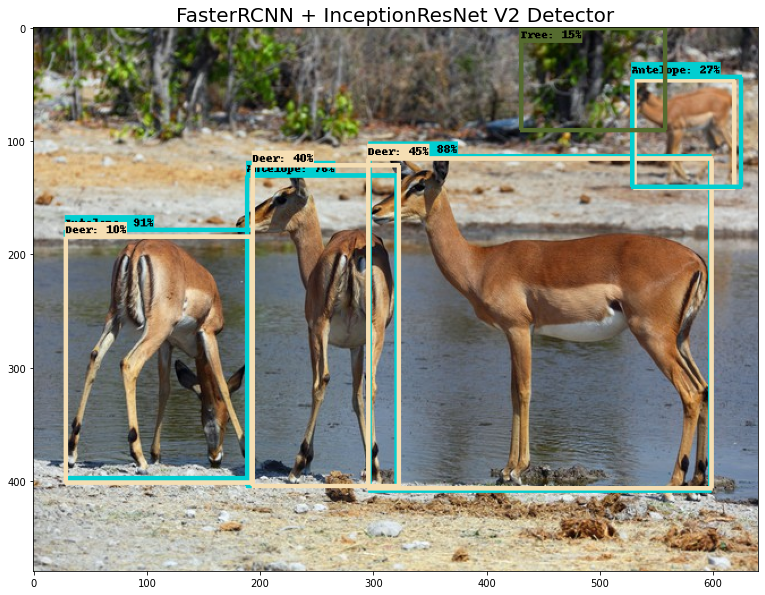

In [6]:
for index, url in enumerate(image_urls):
    display(Markdown('## Inference on image '+ str(index +1)))
    object_detector(ssd_detector,"SSD + MobileNetV2 Detector" ,  url)
    plt.show()
    object_detector(icp_res2_detector,"FasterRCNN + InceptionResNet V2 Detector" ,  url )
    plt.show()